### Installation

In [1]:
# !pip install tensorflow

In [2]:
# !pip install tensorflow_hub

In [3]:
# !pip install torch

In [4]:
# pip install opencv-python==4.5.5.64

In [5]:
# !pip install imgaug

### Import Libraries

In [6]:
import torch #pytorch
import torchvision
import torch.nn as nn #pytorch network
import torch.nn.functional as F
from torchvision import transforms #torchvision transform

import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### GPU Checking

In [7]:
# Get cpu or gpu device for training.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {DEVICE} device")
if torch.cuda.is_available(): print(f'device name: {torch.cuda.get_device_name(0)}')

Using cuda device
device name: Quadro RTX 4000 with Max-Q Design



### Version Checking

In [8]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


In [9]:
cv2.__version__

'4.5.5'

In [10]:
print(torch.__version__)

1.12.0+cu113


### Data Preprocessing

1) Visualize image and bounding boxes

(1333, 2000, 3)


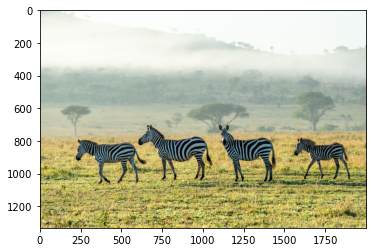

In [11]:
# In this example, only use 1 image, i.e, batch_size=1
# input image could be of any size

img0 = cv2.imread("zebras.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print(img0.shape)
plt.imshow(img0)
plt.show()

In [12]:
# 주어진 하나의 Image에 대한 정답 데이터 지정!
# Bounding Box Label Data와 Class Label Data를 동시에 줘야 Object Detecting 가능!

# object information : a set of bounding boxes [x1, y1, x2, y2] 
# and their labels
bbox0 = np.array([[223, 782, 623, 1074], [597, 695, 1038, 1050], 
                  [1088, 699, 1452, 1057], [1544, 771, 1914, 1063]]) 
labels = np.array([1, 1, 1, 1]) # 0: background, 1: zebra

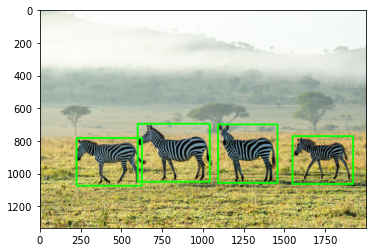

In [13]:
# display bounding box and labels

img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][0], bbox0[i][1]), 
                              (bbox0[i][2], bbox0[i][3]),
                 color=(0, 255, 0), thickness=10)
plt.imshow(img0_clone)
plt.show()

### 2) Resize image and bounding boxes

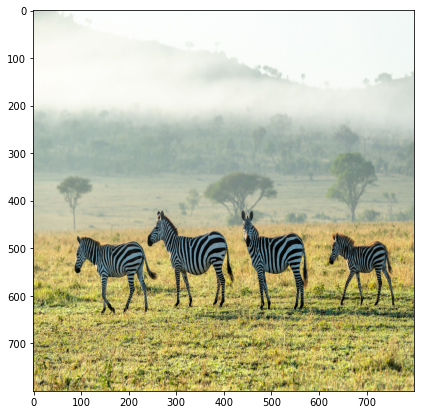

In [14]:
# resize the input images to h=800, w=800
# CNN의 Input으로 들어갈 수 있는 Size로 Resizing!

img = cv2.resize(img0, dsize=(800, 800), interpolation=cv2.INTER_CUBIC)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()

In [15]:
# 기존의 이미지가 Resize되었기에, 같은 비율만큼 Bounding Box도 Resize해야한다.

# change the bounding box coordinates
# original image size : (1333, 2000)

Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]

print(Wratio, Hratio)

0.4 0.6001500375093773


In [16]:
# Example Code of Zip

ratioList = [Wratio, Hratio, Wratio, Hratio]
box = [100,200,300,4000]

for a, b in zip(box,ratioList):
    print(a, b)

100 0.4
200 0.6001500375093773
300 0.4
4000 0.6001500375093773


[[ 89 469 249 644]
 [238 417 415 630]
 [435 419 580 634]
 [617 462 765 637]]


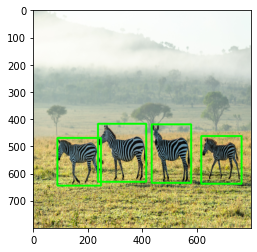

In [17]:
ratioList = [Wratio, Hratio, Wratio, Hratio]
bbox = []

for box in bbox0:
    box = [int(a*b) for a, b in zip(box, ratioList)]
    bbox.append(box)
    
bbox = np.array(bbox)
print(bbox)

img_clone = np.copy(img)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), color=(0, 255, 0), thickness=5)
plt.imshow(img_clone)
plt.show()

### Define Feature extractor

#### 1) Load pretrained VGG16

In [18]:
# only print feature extraction part of VGG16

model_pytorch_pretrained = torchvision.models.vgg16(pretrained=True).to(DEVICE)
model_pytorch_pretrained

features_pytorch_pretrained = list(model_pytorch_pretrained.features)

#### 1) Define VGG16 - PyTorch Ver.

In [19]:
import time
from torch.utils.data import DataLoader


class VGG16(nn.Module):

    def __init__(self):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),     # 0
            nn.ReLU(inplace=True),                                                                           # 1

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),    # 2
            nn.ReLU(inplace=True),                                                                           # 3

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),                    # 4


            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),   # 5
            nn.ReLU(inplace=True),                                                                           # 6

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 7
            nn.ReLU(inplace=True),                                                                           # 8

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),                    # 9


            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 10
            nn.ReLU(inplace=True),                                                                           # 11

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 12
            nn.ReLU(inplace=True),                                                                           # 13

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 14
            nn.ReLU(inplace=True),                                                                           # 15

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),                    # 16
        
        
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 17
            nn.ReLU(inplace=True),                                                                           # 18

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 19
            nn.ReLU(inplace=True),                                                                           # 20

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 21
            nn.ReLU(inplace=True),                                                                           # 22

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),                    # 23


            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 24
            nn.ReLU(inplace=True),                                                                           # 25

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 26
            nn.ReLU(inplace=True),                                                                           # 27

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1,1)),  # 28
            nn.ReLU(inplace=True),                                                                           # 29

            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)                    # 30
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7,7))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),                                      # 0
            nn.ReLU(inplace = True),                                                                         # 1
            nn.Dropout(p=0.5, inplace=False),                                                                # 2
            nn.Linear(in_features=4096, out_features=4096, bias=True),                                       # 3
            nn.ReLU(True),                                                                                   # 4
            nn.Dropout(p=0.5, inplace=False),                                                                # 5
            nn.Linear(in_features=4096, out_features=1000, bias=True)                                        # 6
        )


        # 이 코드는 VGG16 Architecture만 생성한 것!
        
        # 만약,     이 모델을 사용하고 싶다면, Loss Func & Optimizer & Learning Rate & Train Dataset 을 정하고 그에 맞게 Train을 시켜야 한다.
        # 그리고,   Train이 완료된 Model을 model.save를 통해 저장한 뒤에, 저장된 모델 자체를 불러와서 사용해야 한다.

In [20]:
model = VGG16().to(DEVICE)
model

features = list(model.features)

In [21]:
# only collect layers with output feature map size (W, H) < 50
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array  : 4차원 Tensor :: batch size, channel, width, height 순서로 Indexing
print(dummy_img.shape)

req_features = []
output = dummy_img.clone().to(DEVICE)

torch.Size([1, 3, 800, 800])


In [22]:
for feature in features_pytorch_pretrained:
    output = feature(output)
    print(output.size())
    if output.size()[2] < 800//16: # 800/16=50  # Maxpool 5회 실행 :: 800 -> 400 -> 200 -> 100 -> 50 -> 25
        break
    req_features.append(feature)
    out_channels = output.size()[1]  # size[1] 인덱스 = Channel의 수
    
print(len(req_features))
print(out_channels)


# model
# features

# model_pytorch_pretrained
# features_pytorch_pretrained

torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 800, 800])
torch.Size([1, 64, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 400, 400])
torch.Size([1, 128, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 200, 200])
torch.Size([1, 256, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 100, 100])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 50, 50])
torch.Size([1, 512, 25, 25])
30
512


In [23]:
# convert this list into a Seqeuntial module
faster_rcnn_feature_extractor = nn.Sequential(*req_features)
faster_rcnn_feature_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [24]:
# test the results of the input image pass through the feature extractor
transform = transforms.Compose([transforms.ToTensor()])   
# transforms.Compose  - 여러 단계로 변환해야 하는 경우, Compose를 통해 여러 단계를 묶을 수 있다.
#                     - 관련 자료: https://wikidocs.net/157285
# transforms.ToTensor - 데이터를 Tensor로 바꿔준다.
#                     - 관련 자료: https://supermemi.tistory.com/139

imgTensor = transform(img).to(DEVICE)
imgTensor = imgTensor.unsqueeze(0)   # Batch 차원 추가
output_map = faster_rcnn_feature_extractor(imgTensor)

print(output_map.size())   # Batch Size = 1, Channel = 512, Width & Height = 50 임을 확인 가능!   VGG가 제대로 적용된 결과임!

torch.Size([1, 512, 50, 50])


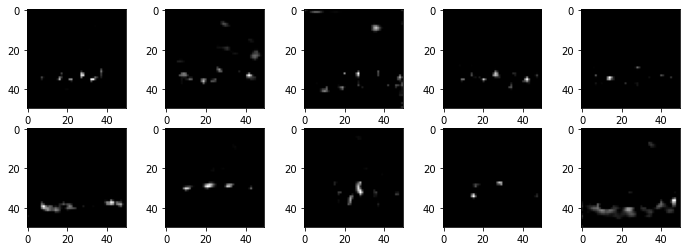

In [25]:
# visualize the first 10 channels of the 50*50*512 feature maps

imgArray = output_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1

for i in range(10):
    fig.add_subplot(2, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
    
plt.show()

### Generate Anchors Boxes

#### 1) Generate Anchors

In [26]:
# sub-sampling rate = 1/16
# image size : 800x800
# sub-sampled feature map size : 800 x 1/16 = 50
# 50 x 50 = 2500 anchors and each anchor generate 9 anchor boxes
# (Because it is faster R-CNN!, each anchor has 3 ratio, 3 scale. so total 9 anchor boxes)

# total anchor boxes = 50 x 50 x 9 = 22500
# x,y intervals to generate anchor box center

feature_size = 800 // 16                               # feature_size = 50
ctr_x = np.arange(16 , (feature_size * 16) + 1 , 16)   # 각 Anchor의 시작 위치!
ctr_y = np.arange(16 , (feature_size * 16) + 1 , 16)
print(len(ctr_x))
print(ctr_x)

50
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [27]:
# coordinates of the 255 center points to generate anchor boxes

index = 0
ctr = np.zeros((2500, 2))

for i in range(len(ctr_x)):              # len(ctr_x) = 50
    for j in range(len(ctr_y)):          # len(ctr_y) = 50
        ctr[index, 1] = ctr_x[i] - 8     # ctr[index, 1] = width   , 각 anchor의 중심 좌표를 모두 생성!
        ctr[index, 0] = ctr_y[j] - 8     # ctr[index, 0] = height  , 각 anchor의 중심 좌표를 모두 생성!
        index += 1

# ctr => [[center x, center y], ...]
print(ctr.shape)
print(ctr[:10, :])

(2500, 2)
[[  8.   8.]
 [ 24.   8.]
 [ 40.   8.]
 [ 56.   8.]
 [ 72.   8.]
 [ 88.   8.]
 [104.   8.]
 [120.   8.]
 [136.   8.]
 [152.   8.]]


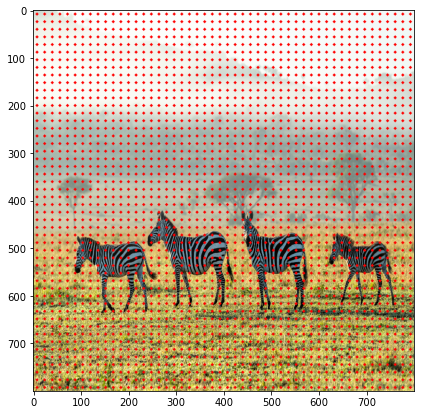

In [28]:
# display the 2500 anchors within image

img_clone2 = np.copy(img)
ctr_int = ctr.astype("int32")

plt.figure(figsize=(7, 7))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone2, (ctr_int[i][0], ctr_int[i][1]),
              radius=1, color=(255, 0, 0), thickness=3)
plt.imshow(img_clone2)
plt.show()

#### 2) Generate Anchor boxes

In [29]:
# for each of the 2500 anchors, generate 9 anchor boxes
# 2500 x 9 = 22500 anchor boxes

ratios = [0.5, 1, 2]   # Ratio는 width : height = 0.5 : 1 = 1 : 1 = 1 : 0.5 총 3개!
scales = [8, 16, 32]   # Scale은 Half Size, Original Size, Double Size로 총 3개! 
sub_sample = 16

anchor_boxes = np.zeros(((feature_size * feature_size * 9), 4))     # feature_size = 50
index = 0

for c in ctr:                        # per anchors : 각 Anchor의 위치를 순차적으로 반환 (Total 2500 Loop)
    ctr_y, ctr_x = c

    for i in range(len(ratios)):     # per ratios
        for j in range(len(scales)): # per scales
            
            # anchor box height, width
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            # h = scales[j] * np.sqrt(ratios[i])
            # w = scales[j] * np.sqrt(1./ ratios[i])

            # anchor box [x1, y1, x2, y2]
            anchor_boxes[index, 1] = ctr_y - h / 2.
            anchor_boxes[index, 0] = ctr_x - w / 2.
            anchor_boxes[index, 3] = ctr_y + h / 2.
            anchor_boxes[index, 2] = ctr_x + w / 2.
            index += 1
            
print(anchor_boxes.shape)
print(anchor_boxes[:10, :])

(22500, 4)
[[ -82.50966799  -37.254834     98.50966799   53.254834  ]
 [-173.01933598  -82.50966799  189.01933598   98.50966799]
 [-354.03867197 -173.01933598  370.03867197  189.01933598]
 [ -56.          -56.           72.           72.        ]
 [-120.         -120.          136.          136.        ]
 [-248.         -248.          264.          264.        ]
 [ -37.254834    -82.50966799   53.254834     98.50966799]
 [ -82.50966799 -173.01933598   98.50966799  189.01933598]
 [-173.01933598 -354.03867197  189.01933598  370.03867197]
 [ -82.50966799  -21.254834     98.50966799   69.254834  ]]


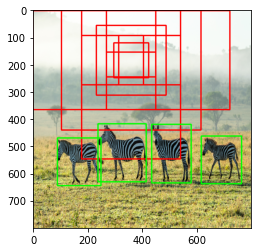

In [30]:
# display the anchor boxes of one anchor and the ground truth boxes

img_clone = np.copy(img)

# draw random anchor boxes : 9개의 box를 랜덤하게 출력
for i in range(10000, 10009):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 0, 0),
                 thickness=3)

# draw ground truth boxes : Label Box도 출력
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), 
                             (bbox[i][2], bbox[i][3]),
                 color=(0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

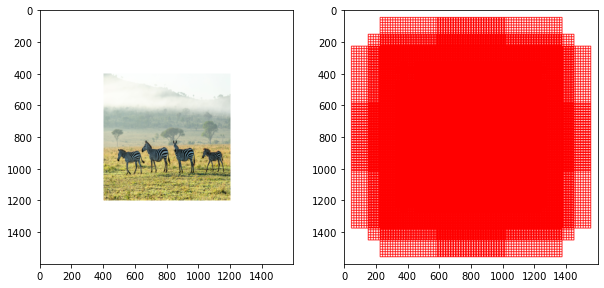

In [31]:
# draw all anchor boxes

padding_size = 400
# add paddings(can't draw anchor boxes out of image boundary)
img_clone3 = np.copy(img)
img_clone4 = cv2.copyMakeBorder(img_clone3, padding_size, padding_size, padding_size, padding_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))
img_clone5 = np.copy(img_clone4)

for i in range(len(anchor_boxes)):
    x1 = int(anchor_boxes[i][0])
    y1 = int(anchor_boxes[i][1])
    x2 = int(anchor_boxes[i][2])
    y2 = int(anchor_boxes[i][3])
    
    cv2.rectangle(img_clone5, (x1+padding_size, y1+padding_size), (x2+padding_size, y2+padding_size), color=(255, 0, 0), thickness=3)

plt.figure(figsize=(10, 10))
plt.subplot(121), plt.imshow(img_clone4)
plt.subplot(122), plt.imshow(img_clone5)
plt.show()

### Target Anchors

#### 1) Only choose anchor boxes inside the image

In [32]:
anchor_boxes

array([[ -82.50966799,  -37.254834  ,   98.50966799,   53.254834  ],
       [-173.01933598,  -82.50966799,  189.01933598,   98.50966799],
       [-354.03867197, -173.01933598,  370.03867197,  189.01933598],
       ...,
       [ 746.745166  ,  701.49033201,  837.254834  ,  882.50966799],
       [ 701.49033201,  610.98066402,  882.50966799,  973.01933598],
       [ 610.98066402,  429.96132803,  973.01933598, 1154.03867197]])

In [33]:
# ignore the cross-boundary anchor boxes
# valid anchor boxes with (x1, y1) > 0 and (x2, y2) <= 800

index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800))[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(8940,)
(8940, 4)


#### 2) Calculate IoUs

In [34]:
number_of_ground_truth_boxes = 4 

ious = np.empty((len(valid_anchor_boxes), number_of_ground_truth_boxes), dtype=np.float32)
ious.fill(0)

print(ious.shape)
print(ious)

(8940, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [35]:
# calculate Iou of the valid anchor boxes
# since we have 8940 anchor boxes and 4 ground truth objects,

# we should get an array with (8940, 4) as the output
# [IoU with gt box1, IoU with gt box2, IoU with gt box3,IoU with gt box4]

# anchor boxes
for i, anchor_box in enumerate(valid_anchor_boxes):
    # enumerate() 함수
    # 인덱스(index)와 원소를 동시에 접근하면서 루프 돌리기🐍
    xa1, ya1, xa2, ya2 = anchor_box
    anchor_area = (xa2 - xa1) * (ya2 - ya1)
    
    # ground truth boxes
    for j, gt_box in enumerate(bbox):     # j = 1 , 2 , 3 , 4   (Because, 4 Ground Truth Boxes)
        xb1, yb1, xb2, yb2 = gt_box
        box_area = (xb2 - xb1) * (yb2 - yb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_x2 - inter_x1) * (inter_y2 - inter_y1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0
        
        ious[i, j] = iou

print(ious.shape)
print(ious[3333:3343, :])
# Index 3333 번째의 Anchor Box는
#     첫 번째 Ground Truth Box와 6.4%  IoU를 가지며
#     두 번째 Ground Truth Box와 40.1% IoU를 가지며
#     세 번째 Ground Truth Box와 3.7%  IoU를 가지며
#     네 번째 Ground Truth Box와 0%    IoU를 가진다.

(8940, 4)
[[0.06410621 0.40119168 0.03715977 0.        ]
 [0.10681152 0.1438179  0.11892319 0.        ]
 [0.         0.27670002 0.         0.        ]
 [0.02111137 0.5752716  0.         0.        ]
 [0.01267202 0.42086694 0.         0.        ]
 [0.11357411 0.33240342 0.12339034 0.        ]
 [0.         0.3920418  0.         0.        ]
 [0.07368252 0.45720294 0.04091056 0.        ]
 [0.10681152 0.1438179  0.11892319 0.        ]
 [0.         0.32188785 0.         0.        ]]


#### 3) Sample positive/negative anchor boxes

In [36]:
# what anchor box has max iou with the ground truth box
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)
# axis를 0으로 지정한 경우(axis = 0)는 가로축 원소들끼리 비교하여 각 가로축에서 argmax를 각각 적용한 결과를 나타낸다.
# axis를 1로 설정(axis = 1)한 경우도 마찬가지의 원리로 세로축 원소끼리의 비교를 진행한 결과를 보여주게 된다.

# [Example Code]
# b = np.array([[4, 3, 2], [8, 5, 9], [7, 6, 1]])
# np.argmax(b) # 5
# np.argmax(b, axis = 0) # array([1, 2, 1])
# np.argmax(b, axis = 1) # array([0, 2, 0])


# 실행결과 : [1008 2862 5935 8699]
#     첫 번째 Ground Truth Box는 1008번째 Index의 Anchor Box와 가장 큰 IoU를 나타낸다.
#     두 번째 Ground Truth Box와 2862번째 Index의 Anchor Box와 가장 큰 IoU를 나타낸다.
#     세 번째 Ground Truth Box와 5935번째 Index의 Anchor Box와 가장 큰 IoU를 나타낸다.
#     네 번째 Ground Truth Box와 8699번째 Index의 Anchor Box와 가장 큰 IoU를 나타낸다.

[1008 2862 5935 8699]


In [37]:
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)


# 실행결과 : [1008 2862 5935 8699]
#     첫 번째 Ground Truth Box는 1008번째 Index의 Anchor Box와 58.5%의 IoU를 나타낸다.
#     두 번째 Ground Truth Box와 2862번째 Index의 Anchor Box와 57.5%의 IoU를 나타낸다.
#     세 번째 Ground Truth Box와 5935번째 Index의 Anchor Box와 52.5%의 IoU를 나타낸다.
#     네 번째 Ground Truth Box와 8699번째 Index의 Anchor Box와 63.2%의 IoU를 나타낸다.

[0.58514285 0.5752716  0.5255493  0.6325869 ]


In [38]:
# what ground truth bbox is associated with each anchor box

argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]     # len(index_inside) = 8940
print(max_ious)


# Image(800 X 800)의 안쪽에 존재하는 Anchor Box 8,940개 각각에서
# 최대 값을 가지는 Index값과, 그 인덱스의 IoU값을 출력하는 코드

(8940,)
[0 0 0 ... 3 3 3]
[0.         0.         0.         ... 0.11051063 0.08043041 0.05193678]


In [39]:
# set the labels of 8940 valid anchor boxes to -1(ignore)

# 일단, Default Label을 negative로 부여하고, 일정 Threshold Value에 속하는 값들을 1과 0으로 Change하는 방식!
#       1 = object
#       0 = background
#      -1 = ignore

label = np.empty((len(index_inside),), dtype=np.int32)     # len(index_inside) = 8940
label.fill(-1)
print(label.shape)
print(label)

(8940,)
[-1 -1 -1 ... -1 -1 -1]


In [40]:
# use IoU to assign 1 (objects) to two kind of anchors
# a) the anchors with the highest IoU overlap with a ground truth box
# b) an anchor that has an IoU overlap higher than 0.7 with ground truth box

# Assign 0 (background) to an anchor if its IoU ratio is lower than 0.3

# 즉,   논문 내용에 의거하여
#       IoU가 70% 이상이면 모두 1로 Labeling, 혹은 70%가 넘지 않더라도 어떠한 값이 Ground Truth Box와 최대 IoU를 가진다면 그 값을 1로 Labeling
#       IoU가 30% 보다 작으면 모두 0으로 Labeling
#       IoU가 30%와 70% 사이, 또 그 값이 최대 IoU값이 아니라면 모두 -1로 Labeling (Default Label)

#       1 = object
#       0 = background
#      -1 = ignore


pos_iou_threshold = 0.7
neg_iou_threshold = 0.3

label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

print(label.shape)
print(label)

(8940,)
[0 0 0 ... 0 0 0]


In [41]:
# Every time mini-batch training take only 256 valid anchor boxes to train RPN
# of which 128 positive examples, 128 negative-examples
# disable leftover positive/negative anchors 

# 논문에 의하면,
#    RPN은 모든 Anchor Box에 대해 전부 Loss를 계산하지 않고 랜덤하게 256개의 Anchor Box만 Sampling해서 학습을 진행할 수 있도록 하고
#    positive Anchor Box와 negative Anchor Box의 비율이 1 : 1정도가 되도록 학습을 진행시킨다고 한다.

n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

In [42]:
pos_index = np.where(label == 1)[0]

if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index,
                                    size    = (len(pos_index) - n_pos),
                                    replace = False)
                                    # pos_index 갯수와 n_pos의 갯수를 동일하게 맞춰주기 위해서,
                                    # 만약, len(pos_index) > n_pos 이라면,
                                    # n_pos 에 비하여 초과된 pos_index 갯수 만큼을 랜덤하게 선택하고 False로 바꿔주면서 맞춰주도록 한다.
    label[disable_index] = -1

print(pos_index)
print(pos_index.shape)

[1008 2862 5935 8699]
(4,)


In [43]:
number_of_PosLabel  = np.sum(label == 1)                # number_of_PosLabel = 4
n_neg               = n_sample * number_of_PosLabel     # n_neg = 1024

neg_index           = np.where(label == 0)[0]           # neg_index.shape = 1024

if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, 
                                    size    = (len(neg_index) - n_neg), 
                                    replace = False)
                                    # neg_index 갯수와 n_neg의 갯수를 동일하게 맞춰주기 위해서,
                                    # 만약, len(neg_index) > n_neg 이라면,
                                    # n_neg 에 비하여 초과된 neg_index 갯수 만큼을 랜덤하게 선택하고 False로 바꿔주면서 맞춰주도록 한다.
    label[disable_index] = -1

print(neg_index)
print(neg_index.shape)

[   0    1    2 ... 8937 8938 8939]
(7469,)


In [44]:
# convert the format of valid anchor boxes [x1, y1, x2, y2]

# For each valid anchor box, find the groundtruth object which has max_iou 
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
width  = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
ctr_y  = valid_anchor_boxes[:, 1] + 0.5 * height   # Bounding Box의 중심 좌표 계산
ctr_x  = valid_anchor_boxes[:, 0] + 0.5 * width    # Bounding Box의 중심 좌표 계산

base_height = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_width  = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_ctr_y  = max_iou_bbox[:, 1] + 0.5 * base_height  # Ground Truth Bounding Box의 중심 좌표 계산
base_ctr_x  = max_iou_bbox[:, 0] + 0.5 * base_width   # Ground Truth Bounding Box의 중심 좌표 계산

eps = np.finfo(height.dtype).eps   # eps = 주어진 DataType에서 표현 가능한 가장 작은 값을 반환
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()

anchor_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(anchor_locs.shape)

(8940, 4)
(8940, 4)


In [45]:
anchor_locs

array([[ 1.24848541,  2.49973296,  0.56971714, -0.03381788],
       [ 1.24848541,  2.41134461,  0.56971714, -0.03381788],
       [ 1.24848541,  2.32295626,  0.56971714, -0.03381788],
       ...,
       [-0.5855728 , -0.63252911,  0.4917556 , -0.03381788],
       [-0.5855728 , -0.72091746,  0.4917556 , -0.03381788],
       [-0.5855728 , -0.80930581,  0.4917556 , -0.03381788]])

In [46]:
# First set the label=-1 and locations=0 of the 22500 anchor boxes, 
# and then fill in the locations and labels of the 8940 valid anchor boxes
# NOTICE: For each training epoch, we randomly select 128 positive + 128 negative 
# from 8940 valid anchor boxes, and the others are marked with -1

anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)
print(anchor_labels[:10])   # 초기, 22,500(50*50*9)개의 Anchor Box에서 '+1'로 Labeling된 것과 '0'으로 Labeling된 것을 덮어 씌우는 과정!

(22500,)
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [47]:
anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)

anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)       
print(anchor_locations[1:10, :])

(22500, 4)
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### RPN(Region Proposal Network)

#### 1) Define RPN

In [48]:
# Send the features of the input image to the Region Proposal Network (RPN), 
# predict 22500 region proposals (ROIs)
in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(DEVICE)   # input size, ouput size, kernel size, stride, padding
conv1.weight.data.normal_(0, 0.01)                                 # mean, std
conv1.bias.data.zero_()


# bounding box regressor
reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(DEVICE)   # input size, ouput size, kernel size, stride, padding
reg_layer.weight.data.normal_(0, 0.01)                                  # mean, std
reg_layer.bias.data.zero_()

# classifier(object or not)
cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(DEVICE)   # input size, ouput size, kernel size, stride, padding
cls_layer.weight.data.normal_(0, 0.01)                                  # mean, std
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

#### 2) Classification and Bounding box regression

In [49]:
x                = conv1(output_map.to(DEVICE))   # output_map = faster_rcnn_feature_extractor(imgTensor)
pred_anchor_locs = reg_layer(x)                   # bounding box regresor output
pred_cls_scores  = cls_layer(x)                   # classifier output  :: 물체가 있냐 없냐를 판단해주는 Layer

print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


# ----------------------------------- DIFF -----------------------------------

In [50]:
# Convert RPN to predict the position and classification format of the anchor box
# Position: [1, 36(9*4), 50, 50] => [1, 22500(50*50*9), 4] (dy, dx, dh, dw)
# Classification: [1, 18(9*2), 50, 50] => [1, 22500, 2] (1, 0)

pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

pred_cls_scores = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500, 2])
torch.Size([1, 22500])


In [51]:
pred_anchor_locs

tensor([[[ 0.0220,  0.0043, -0.0077, -0.0243],
         [-0.0102,  0.0080,  0.0065,  0.0521],
         [-0.0146,  0.0294, -0.0262, -0.0145],
         ...,
         [ 0.0872, -0.0266, -0.0201,  0.0038],
         [ 0.0228,  0.0500,  0.0035,  0.0055],
         [-0.0620,  0.0044, -0.0351, -0.0122]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [52]:
pred_cls_scores

tensor([[[ 0.0120,  0.0213],
         [-0.0347, -0.0206],
         [-0.0111,  0.0055],
         ...,
         [-0.0136,  0.0346],
         [ 0.0237,  0.0487],
         [ 0.0453,  0.0877]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [53]:
objectness_score

tensor([[ 0.0213, -0.0206,  0.0055,  ...,  0.0346,  0.0487,  0.0877]],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [54]:
# According to the 22500 ROIs predicted by RPN and 22500 anchor boxes, 
# calculate the RPN loss¶
print(pred_anchor_locs.shape)
print(pred_cls_scores.shape)

print(anchor_locations.shape)
print(anchor_labels.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 22500, 2])
(22500, 4)
(22500,)


In [55]:
# RPN을 통해서 나온 결과인
#     예측 anchor Box의 location 정보와
#     예측 Classifiaction(물체인지 아닌지)에 대한 정보를
# 정답 데이터가 가지고 있는
#     실제 anchor Box의 location 정보와
#     실제 Classification(물체인지 아닌지)에 대한 정보를 서로 비교하는 단계!

# pred_anchor_locs
# pred_cls_scores

rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape,
      gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


#### 3) Multi-task loss 

In [56]:
rpn_score

tensor([[ 0.0120,  0.0213],
        [-0.0347, -0.0206],
        [-0.0111,  0.0055],
        ...,
        [-0.0136,  0.0346],
        [ 0.0237,  0.0487],
        [ 0.0453,  0.0877]], device='cuda:0', grad_fn=<SelectBackward0>)

In [57]:
gt_rpn_score

tensor([-1, -1, -1,  ..., -1, -1, -1], dtype=torch.int32)

In [58]:
# For classification we use cross-entropy loss
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(DEVICE), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6898, device='cuda:0', grad_fn=<NllLossBackward0>)


In [59]:
# rpn_loc

In [60]:
gt_rpn_score[4800]

tensor(1, dtype=torch.int32)

In [61]:
# only positive samples
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes whick have positive labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([4, 4]) torch.Size([4, 4])
tensor(0.3961, dtype=torch.float64, grad_fn=<SumBackward0>)


In [62]:
# Combining both the rpn_cls_loss and rpn_reg_loss

rpn_lambda = 10
N_reg = (gt_rpn_score > 0).float().sum()
print(N_reg)

rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(4.)
tensor(1.6802, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


### Proposal layer

#### 1) Transform anchor boxes

In [63]:
# Send the 22500 ROIs predicted by RPN to Fast RCNN to predict bbox + classifications
# First use NMS (Non-maximum supression) to reduce 22500 ROI to 2000

nms_thresh          = 0.7    # non-maximum supression (NMS) 
n_train_pre_nms     = 12000  # no. of train pre-NMS
n_train_post_nms    = 2000   # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms      = 6000
n_test_post_nms     = 300    # During testing we evaluate 300 proposals,
min_size            = 16

In [64]:
# the labelled 22500 anchor boxes
# format converted from [x1, y1, x2, y2] to [ctrx, ctry, w, h]

anc_height = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_width = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_ctr_y = anchor_boxes[:, 1] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 0] + 0.5 * anc_width

print(anc_ctr_x.shape) 
print(anc_ctr_x)

(22500,)
[  8.   8.   8. ... 792. 792. 792.]


In [65]:
# The 22500 anchor boxes location and labels predicted by RPN (convert to numpy)
# format = (dx, dy, dw, dh)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()

dy = pred_anchor_locs_numpy[:, 1::4]
dx = pred_anchor_locs_numpy[:, 0::4]
dh = pred_anchor_locs_numpy[:, 3::4]
dw = pred_anchor_locs_numpy[:, 2::4]
print(dy.shape)

(22500, 1)


In [66]:
# ctr_y = dy predicted by RPN * anchor_h + anchor_cy
# ctr_x similar
# h = exp(dh predicted by RPN) * anchor_h
# w similar

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500, 1)


In [67]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_x - 0.5 * w
roi[:, 1::4] = ctr_y - 0.5 * h
roi[:, 2::4] = ctr_x + 0.5 * w
roi[:, 3::4] = ctr_y + 0.5 * h

print(roi.shape)

(22500, 4)


#### 2) Clip the anchor boxes to the image

In [68]:
# clip the predcited boxes to the image

img_size = (800, 800)
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0]) # [:, 0, 2]
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1]) # [:, 1, 3]

print(roi.shape, np.max(roi), np.min(roi))

(22500, 4) 800.0 0.0


In [69]:
# remove predicted boxes with either height or width < threshold

hs = roi[:, 3] - roi[:, 1]
ws = roi[:, 2] - roi[:, 0]

keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

(22500,) (22500, 4) (22500,)


#### 3) Select top-12000 anchor boxes by objectness score

In [70]:
# sort all (proposal, score) pairs by score from highest to lowest

order = score.ravel().argsort()[::-1]
print(order.shape)

(22500,)


In [71]:
# take top pre_nms_topN (e.g. 12000 while training and 300 while testing)
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape)

(12000,) (12000, 4)


#### 4) Non maximum suppression(select 2000 bounding boxes)

In [72]:
# take all the roi boxes
x1 = roi[:, 0]
y1 = roi[:, 1]
x2 = roi[:, 2]
y2 = roi[:, 3]

# find the areas of all the boxes

areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [73]:
# take the indexes of order the probability score in descending order
# non maximum suppression

order = order.argsort()[::-1]
keep = []

while (order.size > 0):
  i = order[0] # take the 1st elt in roder and append to keep
  keep.append(i)

  xx1 = np.maximum(x1[i], x1[order[1:]])
  yy1 = np.maximum(y1[i], y1[order[1:]])
  xx2 = np.minimum(x2[i], x2[order[1:]])
  yy2 = np.minimum(y2[i], y2[order[1:]])

  w = np.maximum(0.0, xx2 - xx1 + 1)
  h = np.maximum(0.0, yy2 - yy1 + 1)

  inter = w * h
  ovr = inter / (areas[i] + areas[order[1:]] - inter)
  inds = np.where(ovr <= nms_thresh)[0]
  order = order[inds + 1]

keep = keep[:n_train_post_nms] # while training/testing, use accordingly
roi = roi[keep]
print(len(keep), roi.shape)

2000 (2000, 4)


### Proposal Target layer

#### 1) Calculate IoUs

In [74]:
n_sample = 128 # number of samples from roi
pos_ratio = 0.25 # number of positive examples out of the n_samples
pos_iou_thresh = 0.5 # min iou of region proposal with any ground truth object to consider it as positive label
neg_iou_thresh_hi = 0.5 # iou 0~0.5 is considered as negative (0, background)
neg_iou_thresh_lo = 0.0

In [75]:
# fine the iou of each ground truth object with the region proposals

ious = np.empty((len(roi), bbox.shape[0]), dtype = np.float32)
ious.fill(0)

for num1, i in enumerate(roi):
  ya1, xa1, ya2, xa2 = i
  anchor_area = (ya2 - ya1) * (xa2 - xa1)

  for num2, j in enumerate(bbox):
    yb1, xb1, yb2, xb2 = j
    box_area = (yb2 - yb1) * (xb2 - xb1)
    inter_x1 = max([xb1, xa1])
    inter_y1 = max([yb1, ya1])
    inter_x2 = min([xb2, xa2])
    inter_y2 = min([yb2, ya2])

    if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
      inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
      iou = inter_area / (anchor_area + box_area - inter_area)
    else:
      iou = 0
    ious[num1, num2] = iou

print(ious.shape)

(2000, 4)


In [76]:
# find out whick ground truth has high IoU for each region proposal
# also find the maximum IoU

gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)

print(gt_assignment)
print(max_iou)

# assign the labels to each proposal
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)


# Image(800 X 800)의 안쪽에 존재하는 Anchor Box 128개의 Sample중에서
# 최대 값을 가지는 Index값과, 그 인덱스의 IoU값을 출력하는 코드

[3 3 0 ... 0 0 0]
[0.34818158 0.01277754 0.         ... 0.4562215  0.47077185 0.5800421 ]
[1 1 1 ... 1 1 1]


#### 2) Select foreground(positive) samples

In [77]:
# select the foreground rois as pre the pos_iou_thresh
# and n_sample x pos_ratio (128 x 0.25 = 32) foreground samples

pos_roi_per_image = 32
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))

if pos_index.size > 0:
  pos_index = np.random.choice(
      pos_index, size=pos_roi_per_this_image, replace=False)
  
print(pos_roi_per_this_image)
print(pos_index)

18
[1885 1999 1888  341  286 1377 1472 1507  944 1374   37   33 1946  848
   28 1372  403  939]


#### 3) Select background(negative) samples

In [78]:
# similarly we do for negative(background) region proposals

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                     (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))

if neg_index.size > 0:
  neg_index = np.random.choice(
    neg_index, size = neg_roi_per_this_image, replace=False)
  
print(neg_roi_per_this_image)
print(neg_index)

110
[1254 1791 1342 1073 1548  391 1025 1749 1114 1002  293  138  841 1011
 1498  117  679 1476 1880  529 1453 1141  947  539  317 1605  452 1189
  266 1781 1216  438  757  768  226 1133  470 1239   74  684 1159 1480
  862 1171 1954  161  395 1660  406 1198  198 1017 1136  828  974 1340
   65 1985  282  218  733 1124  191  720 1299  377 1590  624  919 1889
  234  781  632  497  552 1774 1763  303 1066 1663 1283  567 1184 1694
   17  777 1105  740  698  942  721 1743  325  820  366  703 1849 1452
  652 1279 1813 1686   48  749 1147 1122  461 1412 1673 1092]


#### 4) Visualization       

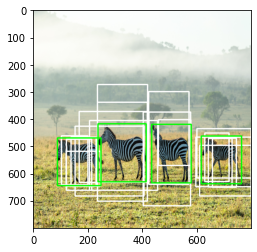

In [79]:
# display RoI samples with positive

img_clone = np.copy(img)

for i in range(pos_roi_per_this_image):
  x1, y1, x2, y2 = roi[pos_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255,255,255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)

plt.imshow(img_clone)
plt.show()

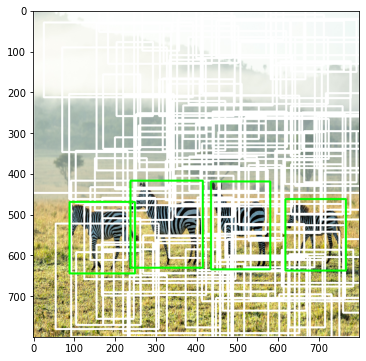

In [80]:
# display RoI samples with negative

img_clone = np.copy(img)

plt.figure(figsize=(9, 6))

for i in range(neg_roi_per_this_image):
  x1, y1, x2, y2 = roi[neg_index[i]].astype(int)
  cv2.rectangle(img_clone, (x1, y1), (x2, y2), color=(255, 255, 255),
                thickness=3)
  
for i in range(len(bbox)):
  cv2.rectangle(img_clone, (bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3]), 
                color = (0, 255, 0), thickness=3)
  
plt.imshow(img_clone)
plt.show()

#### 5) Gather positive/negative samples

In [81]:
# now we gather positive samples index and negative samples index
# their respective labels and region proposals

keep_index                             = np.append(pos_index, neg_index)
gt_roi_labels                          = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0 # negative labels => 0
sample_roi                             = roi[keep_index]
print(sample_roi.shape)     

(128, 4)


In [82]:
# pick the ground truth objects for these sample_roi and
# later parameterized as we have done while assigning locations to 
# anchor boxes

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

(128, 4)


In [83]:
width  = sample_roi[:, 2] - sample_roi[:, 0]
height = sample_roi[:, 3] - sample_roi[:, 1]
ctr_x  = sample_roi[:, 0] + 0.5 * width
ctr_y  = sample_roi[:, 1] + 0.5 * height

base_width  = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_height = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_x  = bbox_for_sampled_roi[:, 0] + 0.5 * base_width
base_ctr_y  = bbox_for_sampled_roi[:, 1] + 0.5 * base_height 

In [84]:
# transform anchor boxes

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dx = (base_ctr_x - ctr_x) / width
dy = (base_ctr_y - ctr_y) / height
dw = np.log(base_width / width)
dh = np.log(base_height / height)

gt_roi_locs = np.vstack((dx, dy, dw, dh)).transpose()
print(gt_roi_locs.shape)

(128, 4)


### RoI pooling

#### 1) Concatenate labels with bbox coordinates

In [85]:
# Take out the features of 128 ROI samples and 
# use max pooling to adjust to the same size, H=7, W=7 (ROI Pooling)

rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

torch.Size([128, 4]) torch.Size([128])


In [86]:
indices_and_rois    = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois    = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 5])


#### 2) RoI pooling

In [87]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [88]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # sub-sampling ratio
rois = rois.long()
num_rois = rois.size(0)

for i in range(num_rois):
  roi = rois[i]
  im_idx = roi[0]
  im = output_map.narrow(0, im_idx, 1)[..., roi[1]:(roi[3]+1), roi[2]:(roi[4]+1)]
  tmp = adaptive_max_pool(im)
  output.append(tmp[0])

output = torch.cat(output, 0)

print(output.size())

torch.Size([128, 512, 7, 7])


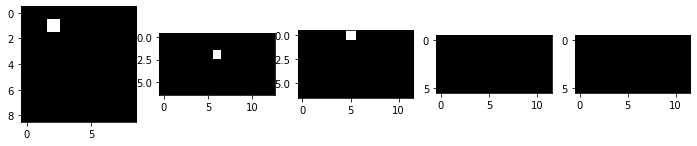

In [89]:
# Visualize the first 5 ROI's feature map (for each feature map, only show the 1st channel of d=512)
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = output_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    
    figNo +=1
plt.show()

In [90]:
# Reshape the tensor so that we can pass it through the feed forward layer.
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


### Fast R-CNN

#### 1) Classifier and Bounding box regressor

In [91]:
# 128 boxes + features (7x7x512) of ROI samples are sent to 
# Detection network to predict the objects bounding box and clas of the input image

roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(DEVICE)
cls_loc = nn.Linear(4096, 2 * 4).to(DEVICE) # 1 class, 1 background, 4 coordiinates
cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(DEVICE) # 1 class, 1 background

In [92]:
# passing the output of roi pooling to RoI head

k = roi_head_classifier(k.to(DEVICE))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)

print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [93]:
# Calculate the loss of Fast RCNN based on the gt bboxes and features (h, w, d=512) 
# corresponding to these 128 ROIs

# predicted
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

#actual
print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [94]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### 2) Classification loss

In [95]:
# Converting ground truth to torch variable
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

#Classification loss
roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)

torch.Size([128, 4]) torch.Size([128])


#### 3) Regression loss

In [96]:
# regression loss

n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

torch.Size([128, 2, 4])


In [97]:
roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

torch.Size([128, 4])


In [98]:
# for regression we use smooth l1 loss as defined in the Fast R-CNN paper
pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

torch.Size([128, 4])


In [99]:
# take those bounding boxes which have positive labels
mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x ** 2) + ((x >= 1).float() * (x - 0.5))
print(roi_loc_loss.sum())

torch.Size([18, 4]) torch.Size([18, 4])
tensor(3.5092, dtype=torch.float64, grad_fn=<SumBackward0>)


#### 4) Multi-task loss

In [100]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

# total_loss = rpn_loss + roi_loss
# print(total_loss)

tensor([[3.1712, 1.2784, 0.8150, 0.9238],
        [0.9101, 0.8701, 1.6381, 0.7624],
        [1.3701, 0.7540, 1.1426, 0.8200],
        [1.4286, 0.7856, 1.3348, 0.8318],
        [1.6720, 0.8411, 1.0755, 0.8314],
        [0.8620, 0.7506, 1.1390, 2.4155],
        [0.7564, 0.9390, 2.5230, 0.9208],
        [0.7866, 2.4220, 4.2546, 0.8270],
        [0.7917, 0.8351, 0.9289, 1.5866],
        [0.9795, 0.8459, 1.2420, 2.0872],
        [1.2174, 0.8694, 2.2513, 0.8790],
        [1.6221, 1.0209, 1.3713, 0.7728],
        [0.8316, 0.8760, 1.1217, 1.0067],
        [0.7841, 1.2325, 0.9289, 0.7493],
        [1.8605, 1.1910, 1.0742, 1.0846],
        [1.2248, 0.7760, 3.0774, 0.9784],
        [1.2803, 0.7509, 1.4679, 0.8122],
        [0.8071, 0.7973, 1.5343, 1.6299]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
